# Bank Loan Stability
**Author**: Ashley Nilson

**Overview**: This analysis reviews a [bank loan status dataset](https://www.kaggle.com/datasets/zaurbegiev/my-dataset) obtained from [Kaggle](https://www.kaggle.com). The original dataset contains 100,000 samples of individual loans which have either been charged off or paid in full, with various details on the customer and loan itself.

The goal of this analysis is to identify correlations between loans that are charged off versus those that are not. Using the results of this review, we can adapt our approval methods for new loans to reduce the likihood of charge offs for new loans. With that goal in mind, we will conduct a k-cluster, linear regression, and logistic regression analysis.

As we conduct this analysis, the focus will be on recall (sensitivity) false negatives are more impactful to our business functions than false positives since the entire goal of this analysis is to ensure we do not give loans to individual who are likely to have it charged off.

The variables used for the analysis portion of this dataset are:

*  Charged_Off: binary variable
 * Indicates if the loan was charged off (1) or paid in full (0)
*  Loan_Amount: continuous variable
 * Total amount loaned to the customer
*  Credit_Score: continuous variable
 * Customer's credit score
*  Annual_Income: continuous variable
 * Customer's gross pay per year.
*  Employment_Years: continuous variable
 * Total years of employment with current employer
*  Monthly_Debt: continuous variable
 * How much debt the customer has to pay off per month
*  Credit_History_Years: continuous variable
 * Count of the number of years int he customer's credit history
*  Months_Last_Delinquent: continuous variable
 * Count of the number of months since the customer was last delinquent
*  Total_Open_Accts: continuous variable
 * Count of the open accounts the customer has
*  Credit_Problems: continuous variable
 * Count of the customer's credit problems.
*  Credit_Balance: continuous variable
 * Total credit in use for the customer
*  Max_Credit: continuous variable
 * Total credit available to a customer.
*  Bankruptcies: continuous variable
 * Count of a customer's bankruptcies. Note: after removing outliers, this appears as a binary variable since most customers have 1 or 0 bankruptcies.  
*  Num_Loans: continuous variable
 * Total count of the number of loans for an individual customer included in this dataset.
*  Term_Short: binary variable
 * Indicates if the loan is a short-term (1) or long-term (0) loan.
* Home: binary variables generated from categorical column
 * The options are: Home_Own, Home_Rent, or Home_Mortgage. These are used to indicate the customer's housing situation.
* Purpose: variables values generated from categorical column
 * The options are: Purpose_Business, Purpose_Debt, Purpose_Educational_Expenses, Purpose_HomeImprovement, Purpose_MajorPurchase, Purpose_Other, or Purpose_Recreation. These are used to indicate the purpose for the customer's loan.


**Analysis Results Summary**: None of the machine learning models used in this analysis generated a predictive model that performed better than the null hypothesis. This is not to say that creating a model from this dataset is not possible. Rather, it is simply that the methods used to clean and organize the data thus far do not assist the model. As next steps, we would recommend delving deeper into calculations that can be made from the available data (for example, using Monthly_Debt and Annual_Income to create a debt-to-income ratio).

As a note: the model would also be improved by normalizing the training and testing data separately, rather than in bulk as we have in this notebook.

## Preliminaries

To set up the notebook we must install needed packages, set common variables, and establish the working directory. As general best practices, we will also include the date/time for the most recent analysis in GMT.

In [4]:
#install packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import re
from datetime import datetime
from sklearn import metrics, preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances, silhouette_samples, silhouette_score, accuracy_score, confusion_matrix, \
      recall_score, precision_score, f1_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.feature_selection import RFE

#set variable names for processing
mm_scaler = preprocessing.MinMaxScaler()

#date time
now = datetime.now()
print("Analysis on", now.strftime("%Y-%m-%d"), "at", now.strftime("%H:%M"))

Analysis on 2024-07-27 at 09:59
Analysis on 2024-07-27 at 09:59


## Data wrangling

In this section, we'll be importing our dataset and completing some basic modifications to ensure our analysis is not skewed by inaccurate or extreme data representations.


In [5]:
#read in data and review
d = pd.read_csv('data/LOAN-acct_info.csv')

#set loan as index
d = d.set_index('Loan ID')

d.shape

(100000, 18)

In [6]:
#replace spaces with underscores in column names
d.columns = d.columns.str.replace(' ', '_')

#replace spaces with underscores in text values, and review values
for col in list(d.select_dtypes(include=['object', 'category']).columns):
  d[col] = d[col].str.replace(' ', '_')
  print('Unique values from',col,':\n',d[col].unique(),'\n')

Unique values from Customer_ID :
 ['981165ec-3274-42f5-a3b4-d104041a9ca9' '2de017a3-2e01-49cb-a581-08169e83be29' '5efb2b2b-bf11-4dfd-a572-3761a2694725'
 ... '2ced5f10-bd60-4a11-9134-cadce4e7b0a3' '3e45ffda-99fd-4cfc-b8b8-446f4a505f36'
 '1b3014be-5c07-4d41-abe7-44573c375886'] 

Unique values from Loan_Status :
 ['Fully_Paid' 'Charged_Off'] 

Unique values from Term :
 ['Short_Term' 'Long_Term'] 

Unique values from Years_in_current_job :
 ['8_years' '10+_years' '3_years' '5_years' '<_1_year' '2_years' '4_years' '9_years' '7_years' '1_year' nan '6_years'] 

Unique values from Home_Ownership :
 ['Home_Mortgage' 'Own_Home' 'Rent' 'HaveMortgage'] 

Unique values from Purpose :
 ['Home_Improvements' 'Debt_Consolidation' 'Buy_House' 'other' 'Business_Loan' 'Buy_a_Car' 'major_purchase'
 'Take_a_Trip' 'Other' 'small_business' 'Medical_Bills' 'wedding' 'vacation' 'Educational_Expenses' 'moving'
 'renewable_energy'] 

Unique values from Customer_ID :
 ['981165ec-3274-42f5-a3b4-d104041a9ca9' '2de0

In [7]:
#update values in columns containing text for uniformity
d['Years_in_current_job'] = pd.to_numeric(d['Years_in_current_job'].str.replace(r'\D', '', regex=True))
d['Term'] = d['Term'].str.replace('_Term', '', regex=False)
d['Home_Ownership'] = d['Home_Ownership'].str.replace('.*Mortgage', 'Mortgage', regex=True)
d['Home_Ownership'] = d['Home_Ownership'].str.replace('Own.*', 'Own', regex=True)
d['Purpose'] = d['Purpose'].str.replace('.*(Home|energy).*', 'HomeImprovement', regex=True)
d['Purpose'] = d['Purpose'].str.replace('.*(Debt|Bills).*', 'Debt', regex=True)
d['Purpose'] = d['Purpose'].str.replace('.*(wedding|Trip|vacation).*', 'Recreation', regex=True)
d['Purpose'] = d['Purpose'].str.replace('Educational Expenses', 'Education', regex=False)
d['Purpose'] = d['Purpose'].str.replace('(other|moving)', 'Other', regex=True)
d['Purpose'] = d['Purpose'].str.replace('.*(B|b)usiness.*', 'Business', regex=True)
d['Purpose'] = d['Purpose'].str.replace('.*(purchase|Car|House).*', 'MajorPurchase', regex=True)

for col in list(d.select_dtypes(include=['object', 'category']).columns):
  print('Unique values from',col,':\n',d[col].unique(),'\n')

Unique values from Customer_ID :
 ['981165ec-3274-42f5-a3b4-d104041a9ca9' '2de017a3-2e01-49cb-a581-08169e83be29' '5efb2b2b-bf11-4dfd-a572-3761a2694725'
 ... '2ced5f10-bd60-4a11-9134-cadce4e7b0a3' '3e45ffda-99fd-4cfc-b8b8-446f4a505f36'
 '1b3014be-5c07-4d41-abe7-44573c375886'] 

Unique values from Loan_Status :
 ['Fully_Paid' 'Charged_Off'] 

Unique values from Term :
 ['Short' 'Long'] 

Unique values from Home_Ownership :
 ['Mortgage' 'Own' 'Rent'] 

Unique values from Purpose :
 ['HomeImprovement' 'Debt' 'MajorPurchase' 'Other' 'Business' 'Recreation' 'Educational_Expenses'] 

Unique values from Customer_ID :
 ['981165ec-3274-42f5-a3b4-d104041a9ca9' '2de017a3-2e01-49cb-a581-08169e83be29' '5efb2b2b-bf11-4dfd-a572-3761a2694725'
 ... '2ced5f10-bd60-4a11-9134-cadce4e7b0a3' '3e45ffda-99fd-4cfc-b8b8-446f4a505f36'
 '1b3014be-5c07-4d41-abe7-44573c375886'] 

Unique values from Loan_Status :
 ['Fully_Paid' 'Charged_Off'] 

Unique values from Term :
 ['Short' 'Long'] 

Unique values from Home_Own

In [8]:
#review numerical data for anomalies
for col in list(d.select_dtypes(include=['int', 'float']).columns):
  print('Details for',col,
        '\n  Min:',d[col].min(),
        '\n  Max:',d[col].max(),
        '\n  Median:',d[col].median().round(),
        '\n  Mean:',d[col].mean().round(),'\n'
        )

Details for Current_Loan_Amount 
  Min: 10802 
  Max: 99999999 
  Median: 312246.0 
  Mean: 11760447.0 

Details for Credit_Score 
  Min: 585.0 
  Max: 7510.0 
  Median: 724.0 
  Mean: 1076.0 

Details for Annual_Income 
  Min: 76627.0 
  Max: 165557393.0 
  Median: 1174162.0 
  Mean: 1378277.0 

Details for Years_in_current_job 
  Min: 1.0 
  Max: 10.0 
  Median: 6.0 
  Mean: 6.0 

Details for Monthly_Debt 
  Min: 0.0 
  Max: 435843.28 
  Median: 16220.0 
  Mean: 18472.0 

Details for Years_of_Credit_History 
  Min: 3.6 
  Max: 70.5 
  Median: 17.0 
  Mean: 18.0 

Details for Months_since_last_delinquent 
  Min: 0.0 
  Max: 176.0 
  Median: 32.0 
  Mean: 35.0 

Details for Number_of_Open_Accounts 
  Min: 0 
  Max: 76 
  Median: 10.0 
  Mean: 11.0 

Details for Number_of_Credit_Problems 
  Min: 0 
  Max: 15 
  Median: 0.0 
  Mean: 0.0 

Details for Current_Credit_Balance 
  Min: 0 
  Max: 32878968 
  Median: 209817.0 
  Mean: 294637.0 

Details for Maximum_Open_Credit 
  Min: 0.0 
  Ma

In [9]:
#Amount: top value ranges
top = d.query('Current_Loan_Amount > 800000')
print('Min Outlier Values:',top['Current_Loan_Amount'].min(),
      '\nMax Outlier Values:',top['Current_Loan_Amount'].max(),
      '\nCount of values:',len(top.index))

Min Outlier Values: 99999999 
Max Outlier Values: 99999999 
Count of values: 11484
Min Outlier Values: 99999999 
Max Outlier Values: 99999999 
Count of values: 11484


In [10]:
#check the next highest values, as we wouldn't want to remove 10k+ samples
check = d.query('Current_Loan_Amount < 800000')
check['Current_Loan_Amount'].nlargest(2)

Loan ID
4fed402f-4298-4f5c-8d30-05b1f1819c00    789250
b7923e12-395b-49d6-97ee-ca0ed25b65c2    789250
Name: Current_Loan_Amount, dtype: int64

In [11]:
#Replace highest values with 1mil to bring them closer to the standard range
d['Current_Loan_Amount'] = d['Current_Loan_Amount'].replace(99999999, 1000000)

#verify
d['Current_Loan_Amount'].max()

1000000

In [12]:
#Credit scores: review anything outside standard values
d.query('Credit_Score > 800')

,Customer_ID,Loan_Status,Current_Loan_Amount,Term,Credit_Score,Annual_Income,Years_in_current_job,Home_Ownership,Purpose,Monthly_Debt,Years_of_Credit_History,Months_since_last_delinquent,Number_of_Open_Accounts,Number_of_Credit_Problems,Current_Credit_Balance,Maximum_Open_Credit,Bankruptcies,Tax_Liens
Loan ID,,,,,,,,,,,,,,,,,,
89d8cb0c-e5c2-4f54-b056-48a645c543dd,4ffe99d3-7f2a-44db-afc1-40943f1f9750,Charged_Off,206602,Short,7290.0,896857.0,10.0,Mortgage,Debt,16367.74,17.3,NaN,6,0,215308,272448.0,0.0,0.0
0c84b81a-e5a9-4a92-8dc8-fb179add03a4,628b0914-b1d7-4028-b590-b50f5da53d06,Charged_Off,288948,Short,7120.0,537472.0,10.0,Rent,Debt,5777.90,14.8,NaN,4,0,132468,164406.0,0.0,0.0
0daecc08-0354-4753-b282-52124b2420df,2884d362-391a-4941-af69-c825cae18002,Charged_Off,219692,Long,6610.0,527839.0,10.0,Rent,Debt,14207.63,17.0,48.0,9,0,254277,379918.0,0.0,0.0
a5ada080-a058-4ad2-8953-002b7ec1ae31,9966e08c-04a6-41ab-86d0-e4062c64bd41,Charged_Off,78012,Short,7380.0,728726.0,4.0,Rent,MajorPurchase,10135.36,11.4,NaN,8,0,104633,199936.0,0.0,0.0
1704367e-1d71-4551-8d33-49aa15cab4b1,88f97adf-070a-47b1-9657-38276eef7d19,Charged_Off,523908,Long,7370.0,1028774.0,6.0,Mortgage,Debt,22632.99,19.3,NaN,5,0,474658,742720.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5eee6c31-62d4-400c-a81f-37bd373db926,039ee8d2-3321-4683-9592-cb1a360c34e2,Charged_Off,198572,Short,7420.0,526205.0,2.0,Rent,Debt,9910.02,16.5,NaN,8,0,296704,433224.0,0.0,0.0
ce1f8220-7eba-4ec1-8bef-ca28f4916801,3e108ac9-9b7c-44a9-9289-e389cf3085b1,Charged_Off,110924,Short,7070.0,804631.0,4.0,Rent,Debt,11533.00,13.3,61.0,9,0,60154,96470.0,0.0,0.0
096471bd-820e-4d0e-88a7-d699a59ab87a,4cfda7f6-790e-4493-a9b1-4d35a8b63af9,Charged_Off,175362,Short,6880.0,1060162.0,9.0,Rent,Debt,16079.13,17.3,NaN,13,0,277153,333234.0,0.0,0.0


In [13]:
#Credit scores: adjust any with extra 0's (likely typos)
for row in range(0,len(d.index)):
  if d.iloc[row,4] > 800:
    d.iloc[row,4] = d.iloc[row,4]/10

#verify
d.loc['89d8cb0c-e5c2-4f54-b056-48a645c543dd','Credit_Score']

729.0

In [14]:
#Income: review top value ranges
top = d.query('Annual_Income > 10000000')
print('Min Outlier Values:',top['Annual_Income'].min(),
      '\nMax Outlier Values:',top['Annual_Income'].max(),
      '\nTotal Outlier Values:',len(top.index))

Min Outlier Values: 10148546.0 
Max Outlier Values: 165557393.0 
Total Outlier Values: 68
Min Outlier Values: 10148546.0 
Max Outlier Values: 165557393.0 
Total Outlier Values: 68


In [15]:
#Income: remove any at or above 10mil
d = d.query('Annual_Income < 10000000')

In [16]:
d.shape

(80778, 18)

## Data preprocessing

Prior to our analysis we will clean the data to elimitate and account for values that will impact the accuracy of our analysis. In this section we will:


1.   Review samples with null values to remove or fill in those values according to use case.
2. Review outliers for each numerical variable to adjust and remove as needed.
3.   Establish an additional column that has a count of total loans in this dataset for each customer.
4. Make binary columns for text-based column values to ensure all data is numerical.



In [17]:
#check for NaN
print(d.isna().sum())
print('\nRows with Missing Data:', d.isnull().any(axis=1).sum())

Customer_ID                         0
Loan_Status                         0
Current_Loan_Amount                 0
Term                                0
Credit_Score                        0
Annual_Income                       0
Years_in_current_job             3412
Home_Ownership                      0
Purpose                             0
Monthly_Debt                        0
Years_of_Credit_History             0
Months_since_last_delinquent    42637
Number_of_Open_Accounts             0
Number_of_Credit_Problems           0
Current_Credit_Balance              0
Maximum_Open_Credit                 1
Bankruptcies                      161
Tax_Liens                           6
dtype: int64

Rows with Missing Data: 44386
Customer_ID                         0
Loan_Status                         0
Current_Loan_Amount                 0
Term                                0
Credit_Score                        0
Annual_Income                       0
Years_in_current_job             3412
Home_O

In [18]:
#drop rows with na values in columns that have few na values
d = d.dropna(subset = ['Maximum_Open_Credit','Tax_Liens'])

#review na col details
nacol = d.columns[d.isna().any()].tolist()
for col in nacol:
  print('Details for',col,
        '\n  Min:',d[col].min(),
        '\n  Max:',d[col].max(),
        '\n  Median:',d[col].median().round(),
        '\n  Mean:',d[col].mean().round(),'\n'
        )

Details for Years_in_current_job 
  Min: 1.0 
  Max: 10.0 
  Median: 6.0 
  Mean: 6.0 

Details for Months_since_last_delinquent 
  Min: 0.0 
  Max: 176.0 
  Median: 32.0 
  Mean: 35.0 

Details for Bankruptcies 
  Min: 0.0 
  Max: 7.0 
  Median: 0.0 
  Mean: 0.0 

Details for Years_in_current_job 
  Min: 1.0 
  Max: 10.0 
  Median: 6.0 
  Mean: 6.0 

Details for Months_since_last_delinquent 
  Min: 0.0 
  Max: 176.0 
  Median: 32.0 
  Mean: 35.0 

Details for Bankruptcies 
  Min: 0.0 
  Max: 7.0 
  Median: 0.0 
  Mean: 0.0 



In [19]:
#fill in median remaining na values
d = d.fillna(d.median(numeric_only = True))

Now that we've removed the most obvious data errors and outliers, we'll conduct a visual review to make further adjustments on samples that might skew our data.

<Axes: xlabel='Current_Loan_Amount'>

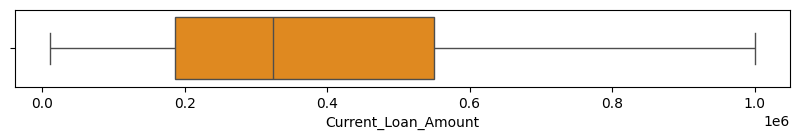

In [20]:
plt.figure(figsize=(10,1))
sns.boxplot(x=d['Current_Loan_Amount'], color='darkorange')

<Axes: xlabel='Credit_Score'>

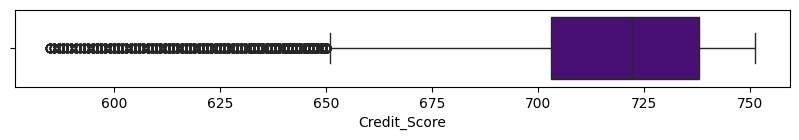

In [21]:
plt.figure(figsize=(10,1))
sns.boxplot(x=d['Credit_Score'], color='indigo')

<Axes: xlabel='Annual_Income'>

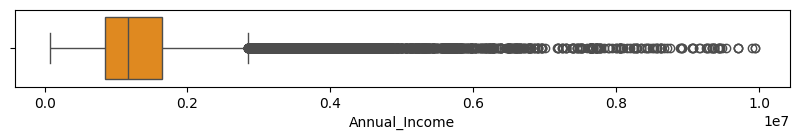

In [22]:
plt.figure(figsize=(10,1))
sns.boxplot(x=d['Annual_Income'], color='darkorange')

In [23]:
#review count of upper income values to determine cutoff
len(d[d["Annual_Income"] > 5000000])

513

In [24]:
#limit dataframe to values below cutoff
d = d.query('Annual_Income < 5000000')
d.shape

(80258, 18)

<Axes: xlabel='Years_in_current_job'>

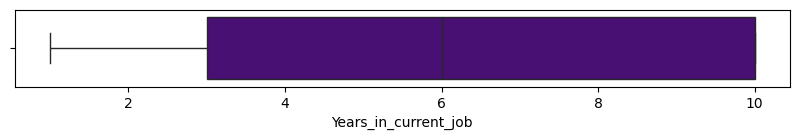

In [25]:
plt.figure(figsize=(10,1))
sns.boxplot(x=d['Years_in_current_job'], color='indigo')

<Axes: xlabel='Monthly_Debt'>

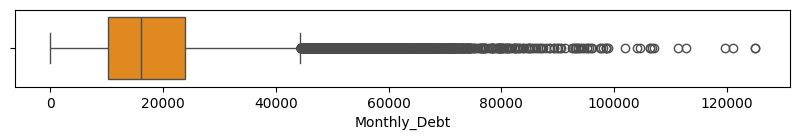

In [26]:
plt.figure(figsize=(10,1))
sns.boxplot(x=d['Monthly_Debt'], color='darkorange')

In [27]:
#count outliers to help determine cutoff
len(d[d["Monthly_Debt"] > 100000])

13

In [28]:
#limit dataframe to remove outliers
d = d.query('Monthly_Debt < 100000')
d.shape

(80245, 18)

<Axes: xlabel='Years_of_Credit_History'>

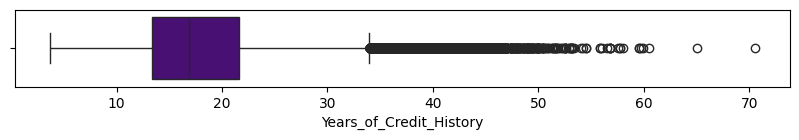

In [29]:
plt.figure(figsize=(10,1))
sns.boxplot(x=d['Years_of_Credit_History'], color='indigo')

In [30]:
#count outliers to help determine cutoff
len(d[d["Years_of_Credit_History"] > 50])

65

In [31]:
#limit dataframe to remove outliers
d = d.query('Years_of_Credit_History < 50')
d.shape

(80176, 18)

<Axes: xlabel='Months_since_last_delinquent'>

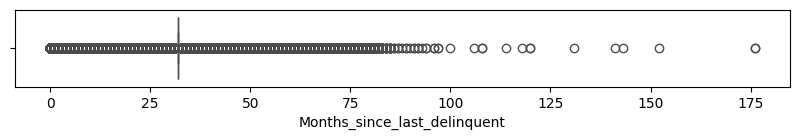

In [32]:
plt.figure(figsize=(10,1))
sns.boxplot(x=d['Months_since_last_delinquent'], color='darkorange')

In [33]:
#count outliers to help determine cutoff
len(d[d["Months_since_last_delinquent"] > 99])

14

In [34]:
#limit dataframe to remove outliers
d = d.query('Months_since_last_delinquent < 100')
d.shape

(80162, 18)

<Axes: xlabel='Number_of_Open_Accounts'>

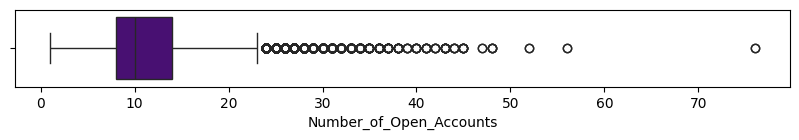

In [35]:
plt.figure(figsize=(10,1))
sns.boxplot(x=d['Number_of_Open_Accounts'], color='indigo')

In [36]:
#count outliers to help determine cutoff
len(d[d["Number_of_Open_Accounts"] > 30])

301

In [37]:
#limit dataframe to remove outliers
d = d.query('Number_of_Open_Accounts < 30')
d.shape

(79775, 18)

<Axes: xlabel='Number_of_Credit_Problems'>

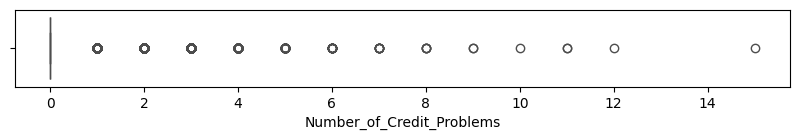

In [38]:
plt.figure(figsize=(10,1))
sns.boxplot(x=d['Number_of_Credit_Problems'], color='darkorange')

In [39]:
#count outliers to help determine cutoff
len(d[d["Number_of_Credit_Problems"] > 2])

476

In [40]:
#limit dataframe to remove outliers
d = d.query('Number_of_Credit_Problems < 2')
d.shape

(78258, 18)

<Axes: xlabel='Current_Credit_Balance'>

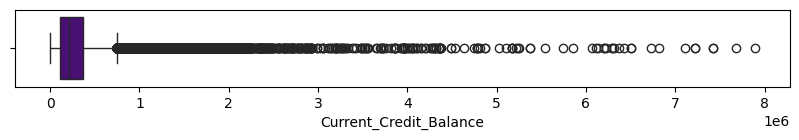

In [41]:
plt.figure(figsize=(10,1))
sns.boxplot(x=d['Current_Credit_Balance'], color='indigo')

In [42]:
#review count of upper credit balances to determine cutoff
len(d[d["Current_Credit_Balance"] > 1500000])

728

In [43]:
#limit dataframe to below cutoff
d = d.query('Current_Credit_Balance < 1500000')
d.shape

(77530, 18)

<Axes: xlabel='Maximum_Open_Credit'>

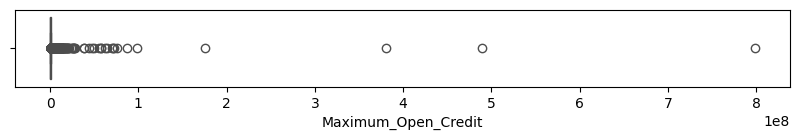

In [44]:
plt.figure(figsize=(10,1))
sns.boxplot(x=d['Maximum_Open_Credit'], color='darkorange')

In [45]:
#review count of maximum open credit to determine cutoff
len(d[d["Maximum_Open_Credit"] > 2500000])

728

In [46]:
#limit dataframe to below cutoff
d = d.query('Maximum_Open_Credit < 2500000')
d.shape

(76802, 18)

<Axes: xlabel='Bankruptcies'>

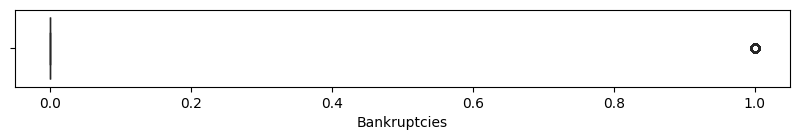

In [47]:
plt.figure(figsize=(10,1))
sns.boxplot(x=d['Bankruptcies'], color='indigo')

In [48]:
#review count of individuals with bankrupcies
len(d[d["Bankruptcies"] > 0]) #do not remove bankruptcies

8016

(76802, 18)

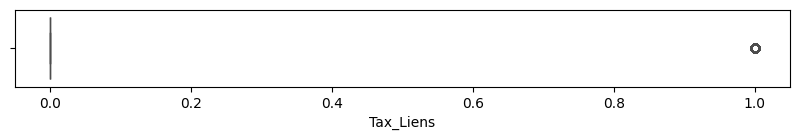

In [49]:
plt.figure(figsize=(10,1))
sns.boxplot(x=d['Tax_Liens'], color='darkorange')
d.shape

In [50]:
#review count of individuals with bankrupcies
len(d[d["Tax_Liens"] > 0])

750

In [51]:
#remove rows with tax liens
d = d.query('Tax_Liens == 0')
d = d.drop(columns = 'Tax_Liens')
d.shape

(76052, 17)

In [52]:
#make new column to account for customers with more than one lean in this list
dupcust = pd.DataFrame(d.pivot_table(index = ['Customer_ID'], aggfunc ='size'),columns=['Num_Loans']).reset_index()
d = d.merge(dupcust, on='Customer_ID', how='left').drop(columns = 'Customer_ID')

#make dummies values for categorical values
d = pd.get_dummies(d, columns=list(d.select_dtypes(include=['object', 'category']).columns), drop_first=False)

#drop columns are duplicative
d = d.drop(columns={'Loan_Status_Fully_Paid','Term_Long'})

#rename columns
d = d.rename(columns = {'Current_Loan_Amount': 'Loan_Amount',
                        'Years_in_current_job': 'Employment_Years',
                        'Years_of_Credit_History': 'Credit_History_Years',
                        'Months_since_last_delinquent': 'Months_Last_Delinquent',
                        'Number_of_Open_Accounts': 'Total_Open_Accts',
                        'Number_of_Credit_Problems': 'Credit_Problems',
                        'Current_Credit_Balance': 'Credit_Balance',
                        'Maximum_Open_Credit': 'Max_Credit',
                        'Loan_Status_Charged_Off': 'Charged_Off',
                        'Home_Ownership_Mortgage': 'Home_Mortgage',
                        'Home_Ownership_Own': 'Home_Own',
                        'Home_Ownership_Rent': 'Home_Rent'})

#move target to front of dataframe
d.insert(0, 'Charged_Off', d.pop('Charged_Off'))

d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76052 entries, 0 to 76051
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Charged_Off                   76052 non-null  bool   
 1   Loan_Amount                   76052 non-null  int64  
 2   Credit_Score                  76052 non-null  float64
 3   Annual_Income                 76052 non-null  float64
 4   Employment_Years              76052 non-null  float64
 5   Monthly_Debt                  76052 non-null  float64
 6   Credit_History_Years          76052 non-null  float64
 7   Months_Last_Delinquent        76052 non-null  float64
 8   Total_Open_Accts              76052 non-null  int64  
 9   Credit_Problems               76052 non-null  int64  
 10  Credit_Balance                76052 non-null  int64  
 11  Max_Credit                    76052 non-null  float64
 12  Bankruptcies                  76052 non-null  float64
 13  N

Charged_Off
False    59735
True     16317
Name: count, dtype: int64 

Charged_Off
False    59735
True     16317
Name: count, dtype: int64 



<Axes: xlabel='Charged_Off', ylabel='count'>

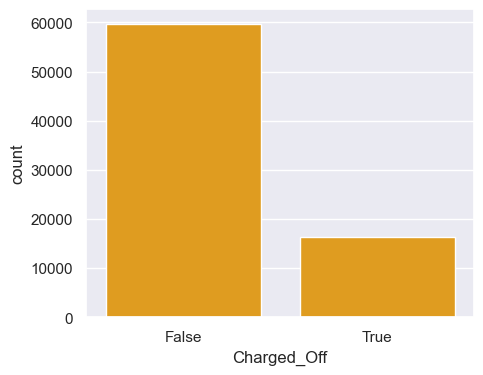

In [53]:
#frequency counts for values in target
freq = d['Charged_Off'].value_counts()
print(freq,'\n')

#visualization of target value counts
sns.set(rc={"figure.figsize":(5, 4)})
sns.countplot(x=d['Charged_Off'], color='orange')

In [54]:
columns = list(d.columns)

#standardize values
d = mm_scaler.fit_transform(d) #normally we would do this later on to individual data, but I'm shortcutting

#refit standardized values into dataframe and verify
d = pd.DataFrame(d, columns=columns)

d.head().transpose()

,0,1,2,3,4
Charged_Off,0.000000,0.000000,0.000000,1.000000,0.000000
Loan_Amount,0.439106,1.000000,0.340249,0.197581,0.208751
Credit_Score,0.746988,0.939759,0.819277,0.867470,0.873494
Annual_Income,0.221779,0.438178,0.148479,0.166757,0.225175
Employment_Years,0.777778,0.777778,0.222222,1.000000,0.000000
Monthly_Debt,0.053349,0.298735,0.089434,0.167449,0.111052
Credit_History_Years,0.292208,0.242424,0.179654,0.294372,0.344156
Months_Last_Delinquent,0.329897,0.298969,0.329897,0.329897,0.103093
Total_Open_Accts,0.178571,0.607143,0.285714,0.178571,0.428571
Credit_Problems,1.000000,1.000000,0.000000,0.000000,1.000000


## Feature selection
At this point we will conduct a feature review to narrow down the variables used for analysis.  

In [55]:
#review correlation between target and features
d.corr()['Charged_Off'].sort_values().round(2)

Num_Loans                      -0.37
Loan_Amount                    -0.15
Credit_Score                   -0.11
Term_Short                     -0.10
Annual_Income                  -0.08
Home_Mortgage                  -0.05
Max_Credit                     -0.03
Credit_History_Years           -0.02
Purpose_HomeImprovement        -0.01
Purpose_MajorPurchase          -0.01
Bankruptcies                   -0.01
Months_Last_Delinquent         -0.01
Credit_Problems                -0.01
Purpose_Recreation             -0.01
Purpose_Other                  -0.01
Employment_Years               -0.01
Purpose_Educational_Expenses   -0.00
Home_Own                        0.00
Credit_Balance                  0.01
Purpose_Debt                    0.01
Total_Open_Accts                0.01
Monthly_Debt                    0.01
Purpose_Business                0.03
Home_Rent                       0.05
Charged_Off                     1.00
Name: Charged_Off, dtype: float64

In [56]:
#limit d to target and features with correlation > |.01|
d = d.drop(columns = {'Purpose_HomeImprovement',
                      'Purpose_MajorPurchase',
                      'Bankruptcies',
                      'Months_Last_Delinquent',
                      'Credit_Problems',
                      'Purpose_Recreation',
                      'Purpose_Other',
                      'Employment_Years',
                      'Purpose_Educational_Expenses',
                      'Home_Own',
                      'Credit_Balance',
                      'Purpose_Debt',
                      'Total_Open_Accts',
                      'Monthly_Debt'})

<Axes: >

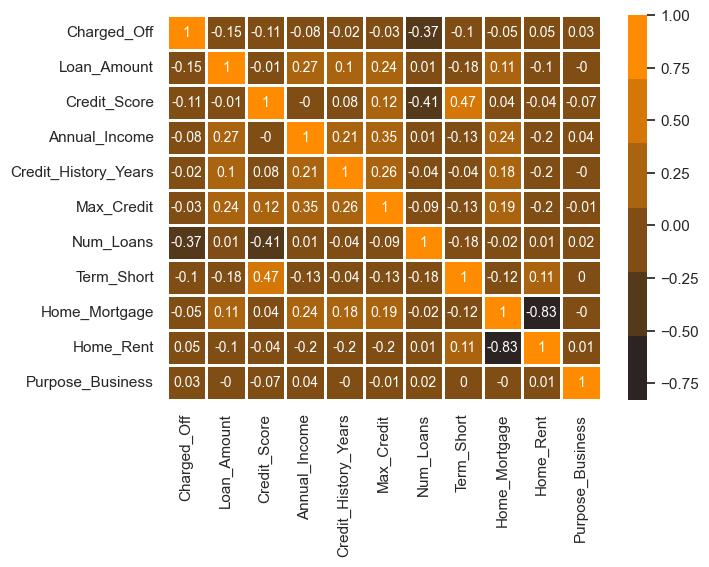

In [57]:
#check for intercorrelation between features
sns.set(rc={"figure.figsize":(7, 5)})
sns.heatmap(d.corr().round(2), linewidths=2.0,
            annot=True, annot_kws={"size": 10},
            cmap=sns.dark_palette("darkorange")
            )

In [58]:
#drop columns with high intercorrelation
d = d.drop(columns='Home_Rent')

#set target and predictors to continue feature selection
y = d['Charged_Off']
pred_vars = list(d.columns[1:])
X = d[pred_vars]

#manual feature selection
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif['Predictor'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i)
  for i in range(X.shape[1])]
cr = d.corr()['Charged_Off'].round(3)
vif['Relevance'] = [cr[i]
  for i in range(X.shape[1])]
vif

<positron-console-cell-58>:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


,Predictor,VIF,Relevance
0,Loan_Amount,3.116823,1.000
1,Credit_Score,13.201130,-0.152
2,Annual_Income,5.214027,-0.108
3,Credit_History_Years,5.628883,-0.077
4,Max_Credit,3.646951,-0.019
5,Num_Loans,1.420106,-0.031
6,Term_Short,4.873710,-0.375
7,Home_Mortgage,2.119601,-0.101
8,Purpose_Business,1.021335,-0.047


In [59]:
#multivariate feature selection
estimator = LinearRegression()
selector = RFE(estimator, n_features_to_select=5, step=1).fit(X,y)

rnk = pd.DataFrame()
rnk['Feature'] = X.columns
rnk['Rank']= selector.ranking_
rnk.sort_values('Rank')

,Feature,Rank
0,Loan_Amount,1
1,Credit_Score,1
2,Annual_Income,1
5,Num_Loans,1
6,Term_Short,1
8,Purpose_Business,2
7,Home_Mortgage,3
3,Credit_History_Years,4
4,Max_Credit,5


In [60]:
#update predictor variables
pred_vars = ['Loan_Amount','Credit_Score','Annual_Income','Num_Loans','Term_Short']
X = d[pred_vars]

## Initial analysis: k-cluster

Prior to completing supervised machine learning, we would like to establish a stronger understanding of the groupings our features. We'll complete this task with a k-cluster analysis, a form of unsupervised machine learning.

In [61]:
#identify features
features = ['Charged_Off','Loan_Amount','Credit_Score','Annual_Income','Num_Loans','Term_Short']
X0 = d[features]

#set arbitrary start for random_state
start = 42

#prep for cluster review
max_nc = 15
inertia = []
silhouette = []

#calculate silhousette and inertia for differing cluster counts
for i in range(2, max_nc):
  model = KMeans(n_clusters=i, init='k-means++', n_init=100, random_state=start)
  model.fit(X0)
  inertia.append(model.inertia_)
  s_score = metrics.silhouette_score(X0, model.labels_, metric='euclidean')
  silhouette.append(s_score)

#print analysis
print('{:>2}{:>11}{:>9}'.format('nc', 'Silhouette', 'Inertia'))
print('-' * 24)
for i in range(2, max_nc):
  print('{:>2d}{:>8.3f}{:>12.3f}'.\
  format(i, silhouette[i-2], inertia[i-2]))

KeyboardInterrupt: 

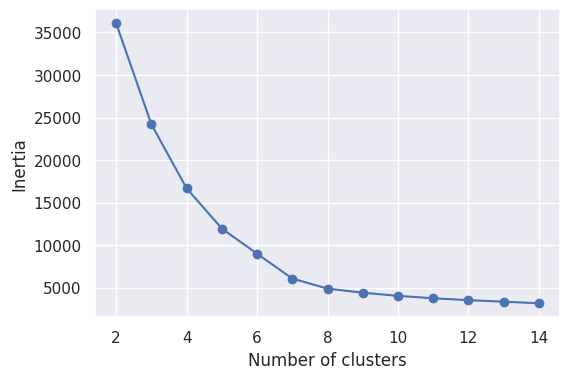

In [ ]:
#set plot for inertia
sns.set(rc={"figure.figsize":(6, 4)})
plt.plot(range(2, max_nc), inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

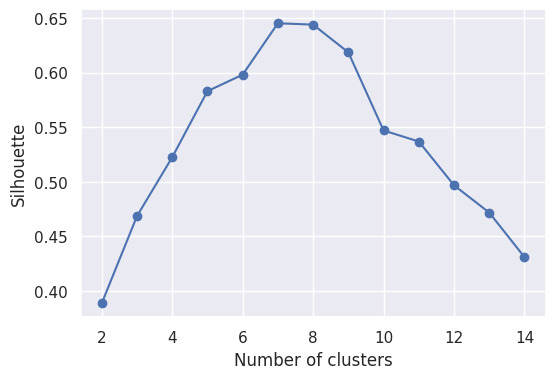

In [ ]:
#set plot for silhouette
plt.plot(range(2, max_nc), silhouette, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette')
plt.show()

In [ ]:
model = KMeans(n_clusters=7, init='k-means++', n_init=100, random_state=start)
model.fit(X0)

KMeans(n_clusters=7, n_init=100, random_state=42)

In [ ]:
_score = metrics.silhouette_score(X0, model.labels_, metric='euclidean')
print('Inertia: %.3f ' % model.inertia_)
print('Mean silhouette score: %.3f' % s_score)

Inertia: 6078.293 
Mean silhouette score: 0.431


Text(0, 0.5, 'Count')

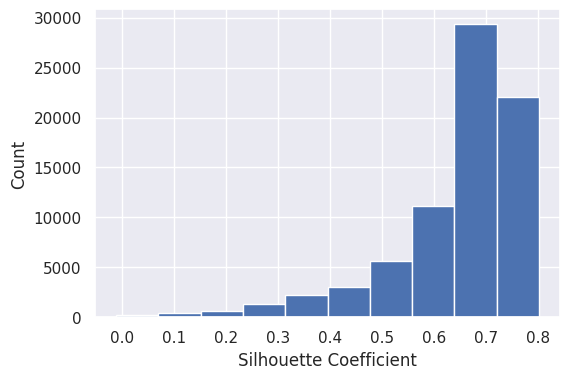

In [ ]:
s_values = silhouette_samples(X0, model.labels_)
plt.hist(s_values.round(3))
plt.xlabel('Silhouette Coefficient')
plt.ylabel('Count')

In [ ]:
dc = d[features].copy()
dc['Cluster'] = model.labels_
dc['S'] = s_values.round(3)
d_lab = pd.DataFrame(model.labels_, columns=['labels'])
count = d_lab['labels'].value_counts()
count

1    20961
0    15606
2    10243
4    10210
6     7558
5     6074
3     5400
Name: labels, dtype: int64

In [ ]:
dcc = pd.DataFrame(model.cluster_centers_,
  columns=list(X0.columns)).round(3)
dcc['Count'] = count
dcc.sort_values('Charged_Off', ascending=False)

,Charged_Off,Loan_Amount,Credit_Score,Annual_Income,Num_Loans,Term_Short,Count
2,1.0,0.249,0.824,0.213,-0.0,1.0,10243
5,1.0,0.423,0.642,0.260,-0.0,-0.0,6074
0,0.0,0.340,0.735,0.230,1.0,1.0,15606
1,0.0,0.232,0.900,0.244,0.0,1.0,20961
3,-0.0,0.509,0.756,0.289,-0.0,-0.0,5400
4,0.0,0.507,0.633,0.287,1.0,-0.0,10210
6,0.0,0.961,0.921,0.280,-0.0,1.0,7558


In [ ]:
avg = dc.groupby(dc['Cluster'])[features].mean().round(2)
d_avg = pd.DataFrame(avg, columns=features).round(3)
d_avg['Count'] = count
d_avg = d_avg.sort_values('Charged_Off', ascending=False)
d_avg

,Charged_Off,Loan_Amount,Credit_Score,Annual_Income,Num_Loans,Term_Short,Count
Cluster,,,,,,,
2,1.0,0.25,0.82,0.21,0.0,1.0,10243
5,1.0,0.42,0.64,0.26,0.0,0.0,6074
0,0.0,0.34,0.74,0.23,1.0,1.0,15606
1,0.0,0.23,0.90,0.24,0.0,1.0,20961
3,0.0,0.51,0.76,0.29,0.0,0.0,5400
4,0.0,0.51,0.63,0.29,1.0,0.0,10210
6,0.0,0.96,0.92,0.28,0.0,1.0,7558


To get a better understanding of the groupings in relation to the target value, we're going to group clusters with no, all, and some charge offs.

In [ ]:
dc['Cluster'] = dc['Cluster'].replace({1,3,4,6}, 0)
dc['Cluster'] = dc['Cluster'].replace({2,5}, 1)

for cluster in range (0,2):
  c = dc[dc['Cluster'] == cluster]
  print('GROUP',cluster,', DETAILS\n','-'*10,'\n',
        'Charge Off Count:',len(c[c['Charged_Off'] == 1]),'/',len(c.index),'\n',
        'Loan Amount Range:',c['Loan_Amount'].min(),'-',c['Loan_Amount'].max(),'\n',
        'Credit Score Range:',c['Credit_Score'].min(),'-',c['Credit_Score'].max(),'\n',
        'Income Range:',c['Annual_Income'].min(),'-',c['Annual_Income'].max(),'\n',
        'Loan Count Range:',c['Num_Loans'].min(),'-',c['Num_Loans'].max(),'\n',
        'Short Term Percent:',len(c[c['Term_Short'] == 1])/len(c.index)*100,'%\n')

GROUP 0 , DETAILS
 ---------- 
 Charge Off Count: 0 / 59735 
 Loan Amount Range: 0.0 - 1.0 
 Credit Score Range: 0.0 - 1.0 
 Income Range: 0.0009077599959826793 - 1.0 
 Loan Count Range: 0.0 - 1.0 
 Short Term Percent: 73.86791663179041 %

GROUP 1 , DETAILS
 ---------- 
 Charge Off Count: 16317 / 16317 
 Loan Amount Range: 0.010324063117567697 - 0.7866980595858644 
 Credit Score Range: 0.0 - 1.0 
 Income Range: 0.0 - 0.9897287922156683 
 Loan Count Range: 0.0 - 0.0 
 Short Term Percent: 62.77501991787706 %



### Summary: K-cluster analysis

Based on final inertia and silhouette scores, the k-cluster analysis did not create distinct enough clusters to use as a standalone analysis. However, the individual clusters did create a full divide between charged-off loans and those that were not charged off. From that, we can see the following trends about loans that are more likely to be charged off:

*   Loan amounts are generally in the middling range (at neither extreme of amount)
*   Usually the only loan the customer has on file with us
* Less likely to be a short term loan

However, further refinement of the data being used prior to analysis would be needed to confirm any of these statements.





## Linear regression
As a basic form of review, we will now conduct a linear regression analysis using the previously identified predictor variables for X and Charged_Off as y.   

In [ ]:
reg_model = LinearRegression()

kf = KFold(n_splits=5, shuffle=True, random_state=1)

scores = cross_validate(reg_model, X, y, cv=kf,
scoring=('r2', 'neg_mean_squared_error'),
                        return_train_score=True)

ds = pd.DataFrame(scores)
ds.rename(columns = {'test_neg_mean_squared_error': 'test_MSE',
'train_neg_mean_squared_error': 'train_MSE'},
inplace=True)
ds['test_MSE'] = -ds['test_MSE']
ds['train_MSE'] = -ds['train_MSE']
print(ds.round(4))

   fit_time  score_time  test_r2  train_r2  test_MSE  train_MSE
0    0.0152      0.0030   0.2615    0.2501    0.1265     0.1259
1    0.0191      0.0031   0.2516    0.2526    0.1236     0.1266
2    0.0191      0.0045   0.2408    0.2553    0.1279     0.1255
3    0.0191      0.0030   0.2537    0.2521    0.1259     0.1260
4    0.0189      0.0031   0.2534    0.2522    0.1261     0.1260


In [ ]:
print('Mean of test R-squared scores: %.3f' % ds['test_r2'].mean(),'\n')
print('Mean of test MSE scores: %.3f' % ds['test_MSE'].mean())

se = np.sqrt(ds['test_MSE'].mean())
print('Standard deviation of mean test MSE scores: %.3f' % se)

Mean of test R-squared scores: 0.252 

Mean of test MSE scores: 0.126
Standard deviation of mean test MSE scores: 0.355


### Summary: Linear regression
As with the k-cluster analysis, the results from our linear regression analysis are inconclusive. While we have a low average for our Mean Squared Errors (MSE), we also have low r-squared scores. As such, the information available from this analysis cannot be used to make accurate predictions at this point.

# Logistic regression

As a final analysis, we will review the data using logistic regression.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30,
                                                    stratify=d['Charged_Off'], random_state=9)
print("size of X data structures: ", X_train.shape, X_test.shape)
print("size of y data structures: ", y_train.shape, y_test.shape)

size of X data structures:  (53236, 5) (22816, 5)
size of y data structures:  (53236,) (22816,)


In [ ]:
logistic_model = LogisticRegression(solver='lbfgs', max_iter=500)
logistic_model.fit(X_train, y_train)

LogisticRegression(max_iter=500)

In [ ]:
print("intercept %.3f" % logistic_model.intercept_, "\n")
cf = pd.DataFrame()
cf['Feature'] = X.columns
cf['Coef']= np.transpose(logistic_model.coef_).round(3)
cf.transpose()

intercept 4.310 



,0,1,2,3,4
Feature,Loan_Amount,Credit_Score,Annual_Income,Num_Loans,Term_Short
Coef,-1.944,-4.337,-0.905,-8.051,-0.702


In [ ]:
y_fit = logistic_model.predict(X_train)
y_pred = logistic_model.predict(X_test)
probs = [i[1] for i in logistic_model.predict_proba(X_test)]
pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_values': y_pred,
                        'pred_probs':probs})

print ('Accuracy for training data: %.3f' % accuracy_score(y_train, y_fit))
print ('Accuracy for testing data: %.3f' % accuracy_score(y_test, y_pred))

Accuracy for training data: 0.818
Accuracy for testing data: 0.818


In [ ]:
dc = pd.DataFrame(confusion_matrix(y_test, y_pred))

print("True Negatives: ", dc.iloc[0,0])
print("True Positives: ", dc.iloc[1,1])
print("False Negatives: ", dc.iloc[1,0])
print("False Positives: ", dc.iloc[0,1])
print('\n')
dc

True Negatives:  17017
True Positives:  1639
False Negatives:  3256
False Positives:  904




,0,1
0,17017,904
1,3256,1639


In [ ]:
print ('Recall for testing data: %.3f' % recall_score(y_test, y_pred))
print ('Precision for testing data: %.3f' % precision_score(y_test, y_pred))
print ('F1 for testing data: %.3f' % f1_score(y_test, y_pred))

Recall for testing data: 0.335
Precision for testing data: 0.645
F1 for testing data: 0.441


In [ ]:
my = y.mean()
max_my = np.max([y.mean(), 1-y.mean()])
print('Proportion of 0\'s (Fully Paid): %.3f' % (1-my))
print('Proportion of 1\'s (Charged Off): %.3f' % my)
print('Null model accuracy: %.3f' % max_my)

Proportion of 0's (Fully Paid): 0.785
Proportion of 1's (Charged Off): 0.215
Null model accuracy: 0.785


### Summary: Logistic regression

For our model, the most important scoring value is recall. We do not want to provide loans to individuals likely to have their loans go into charge-off, and so it's imperative that we have minimal false negatives. However, our model's best score comes from precision, identifying false-positives, and even with that it performs worse than the null model.